# Marshall Flow

In [2]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [3]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [4]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

## 2. Data Import

In [5]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption (%)',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Plastic melted previous to addition?',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    return df

In [5]:
dfMF = returnDf('MF')

## 3. Data Exploration
###  3.1 Total Sample

In [6]:
dfMF = eliminateOutliers(dfMF, 'MF of the sample [mm]')

Initial dataframe size: (316, 34)
Final dataframe size: (296, 34)


In [7]:
dfMF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 1 to 316
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              296 non-null    object 
 1   Global ID                               296 non-null    object 
 2   Modified asphalt Mix?                   296 non-null    object 
 3   Agreggate Type                          149 non-null    object 
 4   Aggregate absorption (%)                176 non-null    float64
 5   Apparent specific gravity               88 non-null     float64
 6   0.075                                   218 non-null    float64
 7   0.3                                     266 non-null    float64
 8   0.6                                     235 non-null    float64
 9   2.36                                    246 non-null    float64
 10  4.75                                    266 non-null    float6

In [8]:
dfMF.iloc[:,2:].describe(include = "all")

,Modified asphalt Mix?,Agreggate Type,Aggregate absorption (%),Apparent specific gravity,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Filler used,Bitumen Type Penetration Grade,Consolidated bitumen penetration grade,New Plastic Type,Plastic pretreatment,Plastic shape,Plastic Size,Plastic particle size (mm),Mixing Process,Mixing speed (RPM),Mixing Temperature,Mixing Time (hours),Aggregates replacement ?,Bitumen replacement?,Filler replacement,Plastic Addition by bitumen weight (%),Property,Units,Bitumen content in the sample,MF of the sample [mm]
count,296,149,176.000000,88.000000,218.000000,266.000000,235.000000,246.000000,266.000000,235.000000,251.000000,266.00000,136,296,296,271,296,296,222,209.000000,296,267.000000,280.000000,267.000000,296,296,296,294.000000,296,296,293.000000,296.000000
unique,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,5,3,10,3,4,4,NaN,3,NaN,NaN,NaN,2,2,2,NaN,1,1,NaN,NaN
top,Yes,Granite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone dust,50/70,50/70,N/a,Physical,Shredded,Fine,NaN,Dry,NaN,NaN,NaN,No,No,No,NaN,MF,mm,NaN,NaN
freq,223,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,121,214,73,212,190,123,NaN,180,NaN,NaN,NaN,280,273,294,NaN,296,296,NaN,NaN
mean,NaN,NaN,0.997244,2.673068,7.120275,16.434098,22.695277,39.547561,50.989211,71.564213,84.311394,94.45797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.221153,NaN,82.022472,17.857143,0.055618,NaN,NaN,NaN,23.592279,NaN,NaN,5.319396,3.420992
std,NaN,NaN,0.864318,0.068539,6.345598,5.793486,6.896635,8.134936,9.562091,13.038299,11.965428,6.71736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.091503,NaN,480.204796,56.553153,0.274352,NaN,NaN,NaN,52.312923,NaN,NaN,0.924330,0.807007
min,NaN,NaN,0.130000,2.590000,2.190000,5.300000,9.000000,20.000000,24.000000,47.000000,66.840000,83.32000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,2.500000,1.640000
25%,NaN,NaN,0.130000,2.600000,5.000000,12.617500,18.900000,35.370000,46.150000,60.510000,78.000000,89.22000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.625000,NaN,NaN,5.000000,2.890000
50%,NaN,NaN,0.800000,2.660000,5.280000,14.470000,20.800000,36.260000,50.130000,70.490000,85.000000,99.01500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.360000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.076923,NaN,NaN,5.250000,3.300000
75%,NaN,NaN,1.020000,2.725000,7.000000,20.000000,23.110000,46.150000,54.770000,79.000000,95.000000,100.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.750000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,13.000000,NaN,NaN,6.000000,3.800000


The mean of the MF observations is 3.42, with and standard deviation of 0.8. In the Australian standards, the MF usually is between 2 and 5.

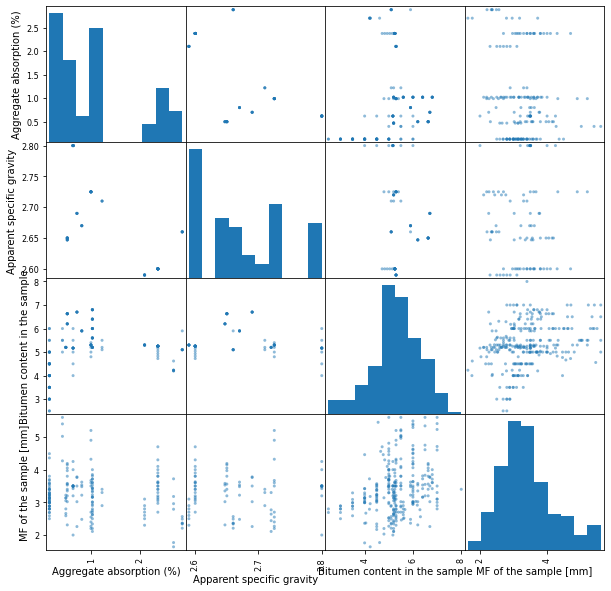

In [9]:
scatter_matrix(dfMF[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'MF of the sample [mm]']], figsize=(10, 10))
plt.show()

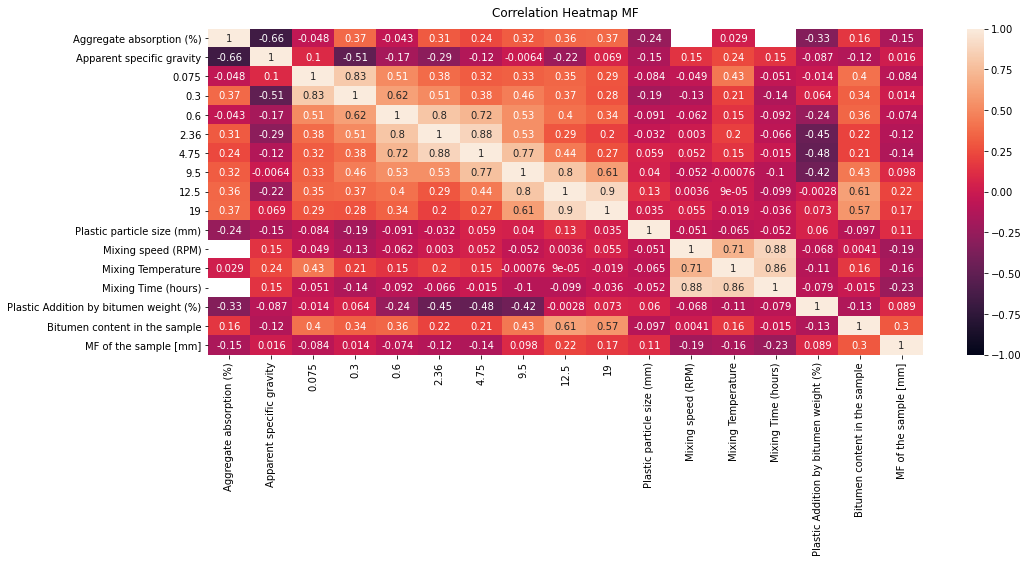

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMF.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MF', fontdict={'fontsize':12}, pad=12);

The strongest correlation of MF is with the $\color{red}{\text{bitumen content}}$ in the sample.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfMF, propertyOfInterest = 'MF of the sample [mm]', columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

The $\color{red}{\text{bitumen type}}$ has similar MF, and it happens the same among the samples $\color{red}{\text{with and without}}$ plastic modification.
###  3.2 Modified mixtures

In [ ]:
dfMFModvsUnmod = dfMF [['Modified asphalt Mix?', 'MF of the sample [mm]']]
dfMFModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfMFModified = dfMF[dfMF['Modified asphalt Mix?'] == 'Yes']
dfMFModified.iloc[:,2:].describe(include = "all")

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['MF of the sample [mm]']
scatter_matrix(dfMFModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMFModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MF', fontdict={'fontsize':12}, pad=12)

Again, in the modified mixtures, the largest positive correlation is with $\color{red}{\text{bitumen content}}$. By looking the graph, one might expect a large correlation with $\color{red}{\text{plastic addition}}$, but this is not the case because many observations were skewed to the left.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfMFModified, propertyOfInterest = "MF of the sample [mm]", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

No significant difference between dry and wet.
###  3.3 Wet vs. Dry Mixing

In [ ]:
dfMFWetvsDry = dfMFModified [['Mixing Process', 'MF of the sample [mm]']]
dfMFWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfMFModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Marshall Flow summary:**

 *  20 outliers were eliminated from the original sample.
 *  Total number of observation: 296 -> $\mu$ = 3.42, $\sigma$ = 0.8
 *  $\color{red}{\text{Agregate absorption}}$ has a high number of missing values; 40 percent of the data points. Nevertheless, it is still an important value according to the Pearson correlation value (r = -0.15)
 *  The variable with the largest positive correlation is $\color{red}{\text{bitumen content}}$ (r = 0.3). It makes sense as higher quantities of bitumen will increase the cohesion of aggregates in the asphalt mixture.
 *  Not much difference between the modified and unmodified mixtures -> $\mu_{modified}$ = 3.44, $\sigma_{modified}$ = 0.8
 *  Modified mixtures present positive correlation with $\color{red}{\text{bitumen content}}$ (r = 0.33), and negative correlation with mixing properties; $\color{red}{\text{shear}}$ (r = -0.24), $\color{red}{\text{temperature}}$ (r = -0.2) and $\color{red}{\text{mixing time}}$ (r = -0.28).
 *  Not significan difference between dry and wet. Dry has 180 observations ($\mu_{dry}$ = 3.49, $\sigma_{dry}$ = 0.79) while wet has 43 observations ($\mu_{wet}$ = 3.24, $\sigma_{wet}$ = 0.81)


## 4. Data Pre-processing

In [7]:
dfMF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 1 to 316
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              296 non-null    object 
 1   Global ID                               296 non-null    object 
 2   Modified asphalt Mix?                   296 non-null    object 
 3   Agreggate Type                          149 non-null    object 
 4   Aggregate absorption (%)                176 non-null    float64
 5   Apparent specific gravity               88 non-null     float64
 6   0.075                                   218 non-null    float64
 7   0.3                                     266 non-null    float64
 8   0.6                                     235 non-null    float64
 9   2.36                                    246 non-null    float64
 10  4.75                                    266 non-null    float6

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration grade}}$, $\color{red}{\text{plastic size}}$, $\color{red}{\text{Property}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
3.  Eliminate rows with missing values in $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic addition by bitumen weight}}$ and $\color{red}{\text{bitumen content in sample}}$.
4.  Change categorical columns to numeric - $\color{red}{\text{Modified asphalt Mix?}}$, $\color{red}{\text{Consolidated bitumen penetration grade}}$, $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic pretreatment}}$, $\color{red}{\text{Plastic shape}}$, $\color{red}{\text{Mixing Process}}$, $\color{red}{\text{Plastic melted previous to addition?}}$, $\color{red}{\text{Replacements}}$.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradation}}$, $\color{red}{\text{plastic size(mm)}}$, and $\color{red}{\text{mixing parameters}}$.

In [8]:
#Categorical Variables
dfMFCleaned = dfMF.drop(['Article ID', 
                        'Global ID',
                        'Agreggate Type',
                        'Modified asphalt Mix?', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade',
                        'Plastic Size', 
                        'Property', 
                        'Units'], axis = 1)
dfMFCleaned = dfMFCleaned.replace('N/a', 0)
dfMFCleaned = dfMFCleaned.dropna(subset=['New Plastic Type', 
                                        'Plastic Addition by bitumen weight (%)', 
                                        'Bitumen content in the sample'])
dfMFCleaned = pd.get_dummies(dfMFCleaned, columns=['New Plastic Type'], drop_first = False)
dfMFCleaned = pd.get_dummies(dfMFCleaned, drop_first=True)
dfMFCleaned = dfMFCleaned.drop(['New Plastic Type_0'], axis = 1)
dfMFCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 1 to 316
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       151 non-null    float64
 1   0.075                                          215 non-null    float64
 2   0.3                                            263 non-null    float64
 3   0.6                                            232 non-null    float64
 4   2.36                                           243 non-null    float64
 5   4.75                                           263 non-null    float64
 6   9.5                                            232 non-null    float64
 7   12.5                                           248 non-null    float64
 8   19                                             263 non-null    float64
 9   Plastic particle size (mm)                     206 non

In [9]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=123), max_iter=100)
n = imputer.fit_transform(dfMFCleaned)
dfMFCleanedImputed = pd.DataFrame(n, columns = list(dfMFCleaned.columns))
dfMFCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfMFCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       268 non-null    float64
 1   0.075                                          268 non-null    float64
 2   0.3                                            268 non-null    float64
 3   0.6                                            268 non-null    float64
 4   2.36                                           268 non-null    float64
 5   4.75                                           268 non-null    float64
 6   9.5                                            268 non-null    float64
 7   12.5                                           268 non-null    float64
 8   19                                             268 non-null    float64
 9   Plastic particle size (mm)                     268 non

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [10]:
dfMFCleanedImputed['New Plastic Type_Nylon'] = dfMFCleanedImputed['New Plastic Type_Nylon'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PE'] = dfMFCleanedImputed['New Plastic Type_PE'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PET'] = dfMFCleanedImputed['New Plastic Type_PET'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PP'] = dfMFCleanedImputed['New Plastic Type_PP'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PS'] = dfMFCleanedImputed['New Plastic Type_PS'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PU'] = dfMFCleanedImputed['New Plastic Type_PU'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PVC'] = dfMFCleanedImputed['New Plastic Type_PVC'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_Plastic Mix'] = dfMFCleanedImputed['New Plastic Type_Plastic Mix'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_e-waste'] = dfMFCleanedImputed['New Plastic Type_e-waste'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed = dfMFCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [11]:
scaler = MinMaxScaler()
dfMFCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfMFCleanedImputed), columns = list(dfMFCleanedImputed.columns))
dfMFCleanedImputedScaled.to_clipboard()

## 5. Model Training

In [12]:
min = dfMFCleanedImputed['MF of the sample [mm]'].min()
max = dfMFCleanedImputed['MF of the sample [mm]'].max()
print('The min value is: '+str(min)+'. The max value is: '+str(max))

The min value is: 1.64. The max value is: 5.6


In [13]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModelAdv (grid, estimator = n, advancedAnalysis = False):
    min = dfMFCleanedImputed['MF of the sample [mm]'].min()
    max = dfMFCleanedImputed['MF of the sample [mm]'].max()
    mse = -grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best Test MSE: ' + str(mse))
    print('Std of the Test MSE:' + str(grid.cv_results_['std_test_neg_mean_squared_error'][grid.best_index_]))
    print('Best Test RMSE: ' +str(math.sqrt(mse)))
    print('Best Test scaled RMSE: ' +str((math.sqrt(mse)*(max-min))+min))
    print('Best Test scaled MSE: ' +str(((math.sqrt(mse)*(max-min))+min)**2)) 
    print('Best Test R2: ' + str(grid.cv_results_['mean_test_r2'][grid.best_index_]))
    if (advancedAnalysis):
        bestEstimator = estimator
        bestEstimator.fit(X_train, y_train)
        predictionsTrain = bestEstimator.predict(X_train)
        df = pd.DataFrame({'predictions':predictionsTrain, 'original': y_train})
        df.plot.hist(bins=10, alpha=0.5)
        unScaledDf = (df*(max-min))+min
        print (unScaledDf.describe())

In [14]:
X = dfMFCleanedImputedScaled.loc[:, dfMFCleanedImputedScaled.columns != 'MF of the sample [mm]']
X.columns = X.columns.astype(str)
y = dfMFCleanedImputedScaled.loc[:,'MF of the sample [mm]']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 123)

In [15]:
y_train_new = y_train.to_frame()
y_train_new['y_train_unscaled'] = (y_train*(max-min))+min

In [16]:
y_train_new.describe()

,MF of the sample [mm],y_train_unscaled
count,214.000000,214.000000
mean,0.458090,3.454036
std,0.215104,0.851812
min,0.000000,1.640000
25%,0.315657,2.890000
50%,0.419192,3.300000
75%,0.559975,3.857500
max,1.000000,5.600000


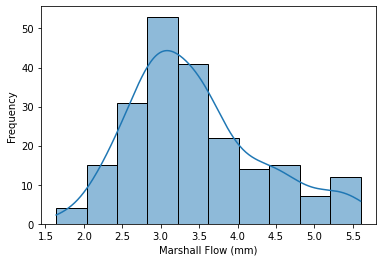

In [17]:
g = sns.histplot(data=y_train_new, x="y_train_unscaled", bins=10, kde=True)
g.set_ylabel('Frequency')
g.set_xlabel('Marshall Flow (mm)')
plt.show()

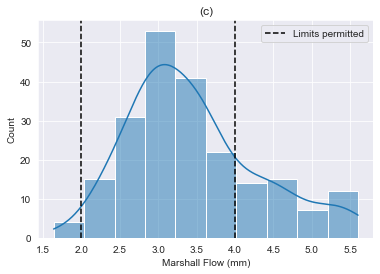

In [18]:
sns.set_style('darkgrid')
fig, ax = plt.subplots()
sns.histplot(x=y_train_new["y_train_unscaled"], bins=10, kde=True, ax = ax)
ax.set(xlabel='Marshall Flow (mm)')
ax.axvline(x=2, label='Limits permitted' , linestyle = '--', color='k')
ax.axvline(x=4 , linestyle = '--', color='k')
ax.set_title('(c)')
ax.legend()
plt.show()

In [22]:
y_train_new[y_train_new["y_train_unscaled"]<2.0]

2

### 5.1 Model Evaluation
#### Linear Model

In [19]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv = cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid) 

Best Parameters: {'fit_intercept': True, 'positive': True}
Best Test MSE: 0.03790559226727287
Std of the Test MSE:0.013813090699867392
Best Test RMSE: 0.19469358558327718
Best Test scaled RMSE: 2.4109865989097776
Best Test scaled MSE: 5.812856380122537
Best Test R2: 0.16005904353106523


#### Lasso Linear Model

In [20]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

Best Parameters: {'alpha': 0.001, 'fit_intercept': True, 'positive': False}
Best Test MSE: 0.02716685747076986
Std of the Test MSE:0.006915830264248088
Best Test RMSE: 0.16482371634801182
Best Test scaled RMSE: 2.292701916738127
Best Test scaled MSE: 5.256482079014681
Best Test R2: 0.39119057944127805


#### Ridge Linear Regression Model

In [21]:
param_grid = {'alpha': [7, 8, 10,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

Best Parameters: {'alpha': 7, 'fit_intercept': True, 'solver': 'sag'}
Best Test MSE: 0.0343751955484263
Std of the Test MSE:0.006906793948599417
Best Test RMSE: 0.18540548953153005
Best Test scaled RMSE: 2.374205738544859
Best Test scaled MSE: 5.636852888939339
Best Test R2: 0.23589130564007849


#### Linear elastic Net

In [34]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

Best Parameters: {'alpha': 0.01, 'fit_intercept': True}
Best Test MSE: 0.03542805035543678
Std of the Test MSE:0.006927479590268045
Best Test RMSE: 0.18822340544001637
Best Test scaled RMSE: 2.3853646855424646
Best Test scaled MSE: 5.689964683033101
Best Test R2: 0.2141142907793721


#### Polynomial model

In [22]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

Best Parameters: {'linearregression__fit_intercept': False, 'linearregression__positive': True, 'polynomialfeatures__degree': 2}
Best Test MSE: 0.03003704622337021
Std of the Test MSE:0.012531771363563307
Best Test RMSE: 0.173311990997075
Best Test scaled RMSE: 2.326315484348417
Best Test scaled MSE: 5.41174373271921
Best Test R2: 0.33742202192888615


#### Lasso polynomial model

In [23]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1,2, 3, 10, 15, 30],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [2000,3000, 3500]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

Best Parameters: {'lasso__alpha': 1, 'lasso__fit_intercept': True, 'lasso__max_iter': 2000, 'lasso__positive': True, 'polynomialfeatures__degree': 2}
Best Test MSE: 0.046545709531315
Std of the Test MSE:0.006684586547875448
Best Test RMSE: 0.2157445469329758
Best Test scaled RMSE: 2.494348405854584
Best Test scaled MSE: 6.2217739697893055
Best Test R2: -0.03200724058234548


#### Ridge Polynomial Model

In [24]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[20,30,50, 60],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'auto']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

Best Parameters: {'polynomialfeatures__degree': 3, 'ridge__alpha': 20, 'ridge__fit_intercept': True, 'ridge__solver': 'sparse_cg'}
Best Test MSE: 0.01982799873910684
Std of the Test MSE:0.00590243583239022
Best Test RMSE: 0.14081192683543126
Best Test scaled RMSE: 2.1976152302683074
Best Test scaled MSE: 4.829512700307226
Best Test R2: 0.559275745904738


#### Support Vector Regression

In [25]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid', 'poly'],
    'degree':[2,3,4],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.2, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

Best Parameters: {'C': 5, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Test MSE: 0.015715807472274346
Std of the Test MSE:0.00453580020739571
Best Test RMSE: 0.12536270367327895
Best Test scaled RMSE: 2.1364363065461847
Best Test scaled MSE: 4.5643600919287035
Best Test R2: 0.6461559076479577


#### Decision tree regresor

In [28]:
param_grid = {
    'max_depth':[None,2,3,5,10,30,50],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,5],
    'max_leaf_nodes': [None, 5,10]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

Best Parameters: {'max_depth': 30, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 3}
Best Test MSE: 0.02546595003423836
Std of the Test MSE:0.008688078492032836
Best Test RMSE: 0.15958054403415964
Best Test scaled RMSE: 2.271938954375272
Best Test scaled MSE: 5.161706612407805
Best Test R2: 0.4267422226424676


#### Random Forest

Best Parameters: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
Best Test MSE: 0.016429807868386458
Std of the Test MSE:0.005867274647467852
Best Test RMSE: 0.1281788120883731
Best Test scaled RMSE: 2.147588095869957
Best Test scaled MSE: 4.612134629522348
Best Test R2: 0.6297454109944871
       predictions    original
count   214.000000  214.000000
mean      3.454036    3.454036
std       0.851475    0.851812
min       1.640000    1.640000
25%       2.890000    2.890000
50%       3.300000    3.300000
75%       3.857500    3.857500
max       5.600000    5.600000


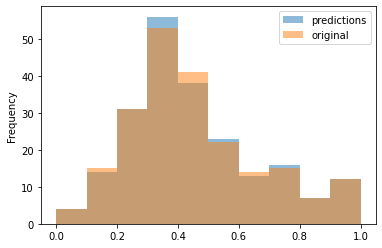

In [29]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10)
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

#### Extra tree regressor

Best Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Best Test MSE: 0.014658291132764187
Std of the Test MSE:0.005260863501257177
Best Test RMSE: 0.12107142987825074
Best Test scaled RMSE: 2.119442862317873
Best Test scaled MSE: 4.492038046630178
Best Test R2: 0.6712043771374491
       predictions    original
count   214.000000  214.000000
mean      3.454036    3.454036
std       0.851475    0.851812
min       1.640000    1.640000
25%       2.890000    2.890000
50%       3.300000    3.300000
75%       3.857500    3.857500
max       5.600000    5.600000


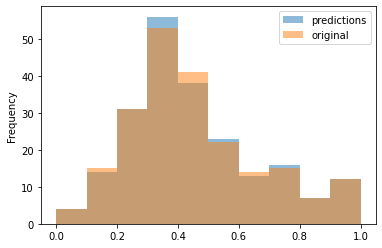

In [17]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [30],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = GridSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

Best Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}
Best Test MSE: 0.014714985533468838
Std of the Test MSE:0.005269523486119654
Best Test RMSE: 0.12130534008636569
Best Test scaled RMSE: 2.120369146742008
Best Test scaled MSE: 4.495965318455431
Best Test R2: 0.670011288396299
       predictions    original
count   214.000000  214.000000
mean      3.454036    3.454036
std       0.851475    0.851812
min       1.640000    1.640000
25%       2.890000    2.890000
50%       3.300000    3.300000
75%       3.857500    3.857500
max       5.600000    5.600000


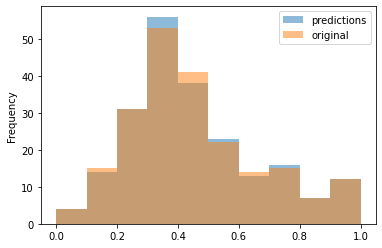

In [30]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10)
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

#### XG Boost Regressor

Best Parameters: {'n_estimators': 1000}
Best Test MSE: 0.01733060191276207
Std of the Test MSE:0.007029097578050932
Best Test RMSE: 0.1316457439979055
Best Test scaled RMSE: 2.161317146231706
Best Test scaled MSE: 4.671291806595165
Best Test R2: 0.6100136776703737
       predictions    original
count   214.000000  214.000000
mean      3.454035    3.454036
std       0.850045    0.851812
min       1.649890    1.640000
25%       2.883840    2.890000
50%       3.302183    3.300000
75%       3.860816    3.857500
max       5.600966    5.600000


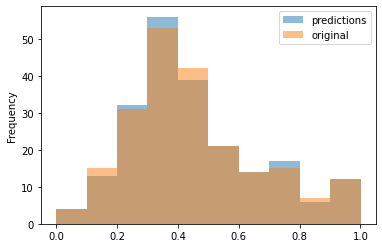

In [17]:
param_grid = {
    'n_estimators': [100,300,500,1000]
}
grid = GridSearchCV(XGBRegressor(random_state=123), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid, XGBRegressor(**grid.best_params_), True)

In [18]:
X_train.columns

Index([                     'Aggregate absorption (%)',
                                                 0.075,
                                                   0.3,
                                                   0.6,
                                                  2.36,
                                                  4.75,
                                                   9.5,
                                                  12.5,
                                                    19,
                          'Plastic particle size (mm)',
                                  'Mixing speed (RPM)',
                                  'Mixing Temperature',
                                 'Mixing Time (hours)',
                       'Bitumen content in the sample',
                              'New Plastic Type_Nylon',
                                 'New Plastic Type_PE',
                                'New Plastic Type_PET',
                                 'New Plastic Ty

In [19]:
X_train2 = X_train.copy()
X_train2.rename(columns={'0.075':'Grad. Sieve size 0.075', '0.3':'Grad. Sieve size 0.3', '0.6':'Grad. Sieve size 0.6', '2.36':'Grad. Sieve size 2.36',                                '4.75':'Grad. Sieve size 4.75','9.5':'Grad. Sieve size 9.5', '12.5':'Grad. Sieve size 12.5', '19':'Grad. Sieve size 19', 
                        'Plastic particle size (mm)':'Plastic size', 'Mixing speed (RPM)':'Mixing speed',
                        'Mixing Time (hours)':'Mixing Time',
                        'Bitumen content in the sample':'Bitumen content', 'New Plastic Type_Nylon':'Plastic Type_Nylon',
                        'New Plastic Type_PE':'Plastic Type_PE', 'New Plastic Type_PET':'Plastic Type_PET', 'New Plastic Type_PP':'Plastic Type_PP',
                         'New Plastic Type_PS':'Plastic Type_PS','New Plastic Type_PU':'Plastic Type_PU', 'New Plastic Type_PVC':'Plastic Type_PVC',
                        'New Plastic Type_Plastic Mix':'Plastic Type_Plastic Mix', 'New Plastic Type_e-waste':'Plastic Type_e-waste' ,
                        'Consolidated bitumen penetration grade_50/70':'Bitumen grade_50/70',
                        'Consolidated bitumen penetration grade_70/100':'Bitumen grade_70/100',
       }, inplace=True)

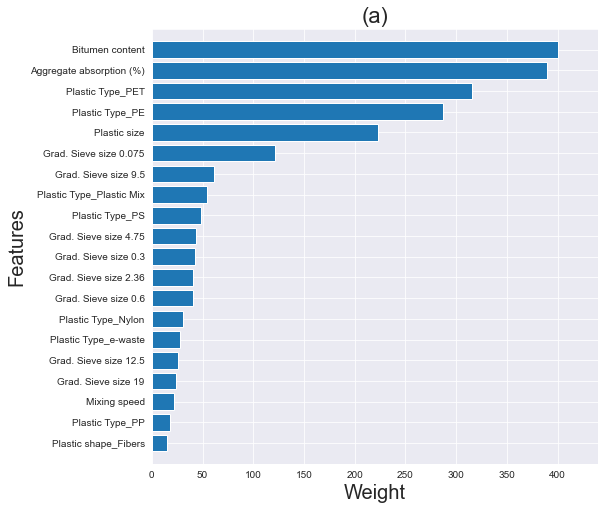

In [22]:
#Graph employed for selecting important features during tunning
XGBoostModel = XGBRegressor(n_estimators= 1000, random_state=123)
XGBoostModel.fit(X_train2,y_train)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='weight', show_values=False, title=None, max_num_features = 20)
fig = ax.figure
plt.xlabel('Weight', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('(a)',fontsize= 22)
fig.set_size_inches(8,8)

## 6. Best Model Tunning

In [23]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 123)

### 6.1. Feature selection

In [24]:
features_MSE = {}
def addMSE (columns, string):
    cv_results = cross_validate(XGBRegressor(n_estimators= 1000, random_state=123), X_train[columns], y_train, cv = cv, scoring = ['neg_mean_squared_error'])
    MSE = np.average(-cv_results['test_neg_mean_squared_error'])
    features_MSE[string] = MSE

In [25]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
       'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [26]:
addMSE(['Bitumen content in the sample'], 
    'Bitumen cont.')

In [27]:
addMSE(['Bitumen content in the sample',
        'Aggregate absorption (%)'], 
'Bitumen cont. \n Aggregates abs.')

In [28]:
addMSE(['Bitumen content in the sample',
        'Aggregate absorption (%)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste'], 
'Bitumen cont. \n Aggregates abs. \n Plastic type')

In [29]:
addMSE(['Bitumen content in the sample',
        'Aggregate absorption (%)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)'], 
'Bitumen cont. \n Aggregates abs. \n Plastic type \n Plastic size')

In [30]:
addMSE(['Bitumen content in the sample',
        'Aggregate absorption (%)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19'], 
'Bitumen cont. \n Aggregates abs. \n Plastic type \n Plastic size \n Gradation')

In [31]:
addMSE(['Bitumen content in the sample',
        'Aggregate absorption (%)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Mixing speed (RPM)'], 
'Bitumen cont. \n Aggregates abs. \n Plastic type \n Plastic size \n Gradation \n Mixing speed')

In [32]:
addMSE(['Bitumen content in the sample',
        'Aggregate absorption (%)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Mixing speed (RPM)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets',
        'Plastic shape_Shredded'], 
'Bitumen cont. \n Aggregates abs. \n Plastic type \n Plastic size \n Gradation \n Mixing speed \n Plastic shape')

In [33]:
addMSE(['Bitumen content in the sample',
        'Aggregate absorption (%)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Mixing speed (RPM)',
        'Plastic shape_Fibers', 'Plastic shape_Pellets',
        'Plastic shape_Shredded',
        'Mixing Time (hours)'], 
        'Bitumen cont. \n Aggregates abs. \n Plastic type \n Plastic size \n Gradation \n Mixing speed \n Plastic shape \n Mixing time')

In [34]:
addMSE(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
       'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'], 
       'All features')

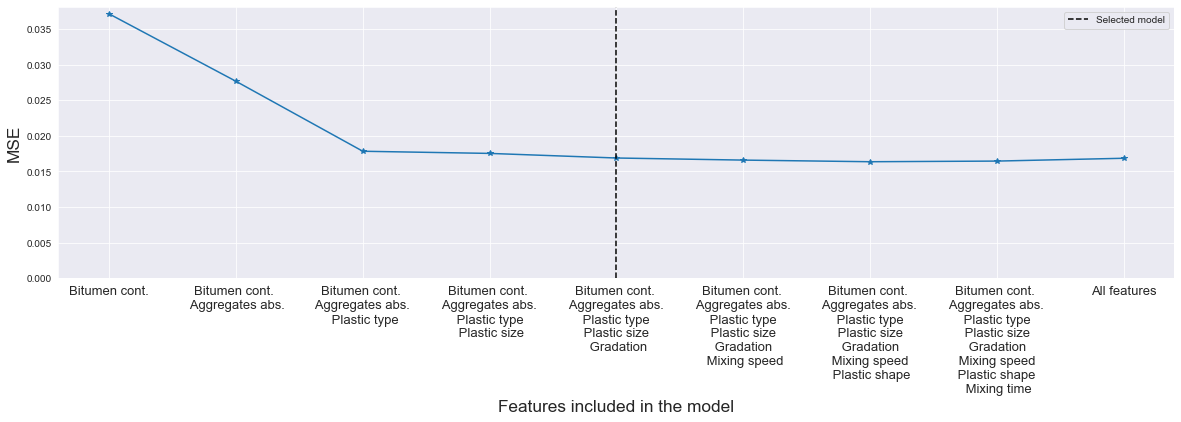

In [36]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(features_MSE.keys(), features_MSE.values(), marker = '*') 
plt.ylim(ymin = 0)
plt.axvline(x='Bitumen cont. \n Aggregates abs. \n Plastic type \n Plastic size \n Gradation', ymin=0, ymax=1, color = 'k', ls = '--' , label='Selected model')
plt.ylabel('MSE', fontsize=20)
plt.xlabel('Features included in the model', fontsize=20)
plt.xticks(fontsize= 13) 
plt.title('(b)', fontsize=22)
plt.legend()
plt.show()

The features most approppiate for the model are aggregates gradation, bitumen content, plastic type, plastic addition, mixing type, and mixing parameters.
### 6.2 Model Tunning

In [19]:
X_train = X_train[['Bitumen content in the sample',
        'Aggregate absorption (%)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19']]
X_test = X_test[['Bitumen content in the sample',
        'Aggregate absorption (%)',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)',
        '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19']]

### 6.3 Final model evaluation on test set

In [28]:
def modelEvaluation (model, Title):
    min = dfMFCleanedImputed['MF of the sample [mm]'].min()
    max = dfMFCleanedImputed['MF of the sample [mm]'].max()
    #Model Fitting
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    #Model Evaluation
    r2_test = r2_score(y_test, predictions_test)
    mse_test = mean_squared_error(y_test, predictions_test)
    rmse_test_unscaled = (math.sqrt(mse_test)*(max-min))+min
    plt.figure(figsize=(7,7))
    #Model Plotting
    plt.scatter(y_test, predictions_test, c='crimson')
    plt.plot([(1,1), (0,0)], [(1,1), (0,0)], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.xlim (0.1,1)
    plt.ylim (0.1,1)
    plt.ylabel('Predictions - ' + Title, fontsize=18)
    plt.annotate('R2 = '+str(round(r2_test,3)), xy = (0.6,0.3), fontweight = 'bold', fontsize = 'xx-large')
    plt.annotate('RMSE = '+str(round(rmse_test_unscaled,3)), xy = (0.6,0.25), fontweight = 'bold', fontsize = 'xx-large')
    plt.show()
    return predictions_test

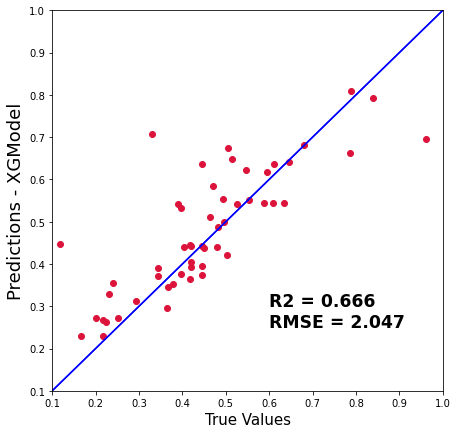

In [29]:
XGModel = XGBRegressor(n_estimators = 1000, random_state=123)
prediction_XGModel = modelEvaluation(XGModel, 'XGModel')

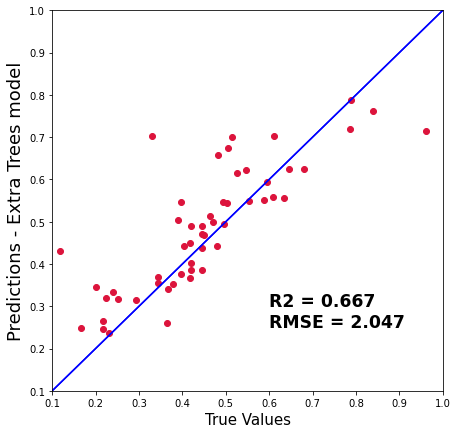

In [30]:
extraTreeModel = ExtraTreesRegressor(n_estimators=1000, min_samples_split=2,min_samples_leaf=1, max_features='auto', max_depth=30, random_state=123, bootstrap=False)
prediction_ExtraTrees = modelEvaluation(extraTreeModel, 'Extra Trees model')

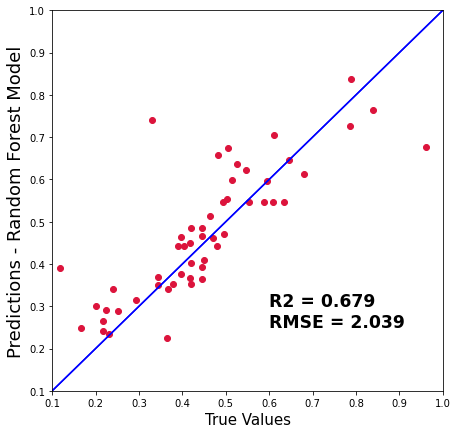

In [31]:
RFModel = RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=60, random_state=123, bootstrap=False)
prediction_RandomForest = modelEvaluation(RFModel, 'Random Forest Model')

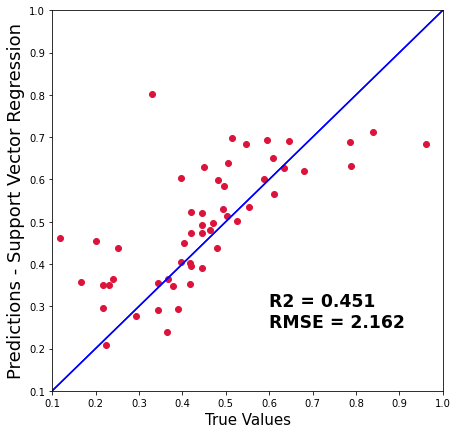

array([0.46163139, 0.27809504, 0.35228818, 0.45382288, 0.43658432,
       0.60301058, 0.53405615, 0.62629629, 0.50099944, 0.20786211,
       0.56435345, 0.36435751, 0.48015025, 0.29534146, 0.52210626,
       0.69170173, 0.62818331, 0.44865874, 0.35763902, 0.68432041,
       0.52028683, 0.23910644, 0.53062963, 0.63913758, 0.34987994,
       0.64961909, 0.80205408, 0.29211582, 0.40237187, 0.38931531,
       0.29410531, 0.49738537, 0.59960382, 0.34987084, 0.39562058,
       0.69334902, 0.60102697, 0.34713151, 0.61965129, 0.69816123,
       0.68279411, 0.47249916, 0.20861105, 0.40465324, 0.51427124,
       0.36512397, 0.71288009, 0.43736443, 0.63117668, 0.58387815,
       0.68892055, 0.49204578, 0.35582545, 0.47249916])

In [23]:
SVREstimator = SVR(C=5, degree=2, epsilon=0.1, kernel='rbf')
modelEvaluation(SVREstimator, 'Support Vector Regression')

### Outliers inspection

In [25]:
XGModel = XGBRegressor(random_state = 123, n_estimators=1000)
XGModel.fit(X_train, y_train)
predictions_test = XGModel.predict(X_test)
df = pd.DataFrame(data=[predictions_test,y_test], index=['prediction', 'y_test']).T
df = df.sort_values(by='y_test')

In [26]:
min = dfMFCleanedImputed['MF of the sample [mm]'].min()
max = dfMFCleanedImputed['MF of the sample [mm]'].max()
df['prediction_uns'] = (df['prediction']*(max-min))+min
df['y_test_uns'] = (df['y_test']*(max-min))+min

In [29]:
df[(df['y_test']<0.4) & (df['y_test']>0.3)]

,prediction,y_test,prediction_uns,y_test_uns
26,0.706963,0.330808,4.439573,2.95
27,0.391203,0.343434,3.189162,3.00
52,0.370928,0.343434,3.108873,3.00
21,0.295823,0.363636,2.811459,3.08
11,0.344553,0.366162,3.004432,3.09
37,0.351861,0.378788,3.033368,3.14
30,0.542013,0.388889,3.786373,3.18
43,0.376913,0.396465,3.132576,3.21
5,0.532667,0.396465,3.749361,3.21


## 6.3 ANOVA Analysis

In [32]:
df_predictions = y_test.to_frame(name='real_Y')
df_predictions['XGModel_predictions'] = prediction_XGModel
df_predictions['ExtraTrees_predictions'] = prediction_ExtraTrees
df_predictions['RandomForest_predictions'] = prediction_RandomForest
def normalityTest (model, data, alpha=0.05):
    k2, p = stats.normaltest(data)
    if p > alpha:
        print ('The ' + model + ' is probably Gaussian. p-value = ' + str(p))
    else:
        print ('The ' + model +' is not probably Gaussian. p-value = '+ str(p))

In [22]:
normalityTest(data = df_predictions['real_Y'], model = 'real values')
normalityTest(data = df_predictions['RandomForest_predictions'], model = 'Random Forest')
normalityTest(data = df_predictions['XGModel_predictions'], model = 'XG model')
normalityTest(data = df_predictions['ExtraTrees_predictions'], model = 'Extra trees')

The real values is probably Gaussian. p-value = 0.20085876953501383
The Random Forest is probably Gaussian. p-value = 0.7094110688030487
The XG model is probably Gaussian. p-value = 0.9335388301564185
The Extra trees is probably Gaussian. p-value = 0.5781524602038344


### Variance homogeneity (Bartlett's test) 

In [27]:
stal, p = stats.bartlett(df_predictions['real_Y'], df_predictions['RandomForest_predictions'], df_predictions['XGModel_predictions'], df_predictions['ExtraTrees_predictions'])
if p > 0.05:
    print('There is not sufficient evidence to say that the variance of the real values and the predictors are differents. The p-value is ' + str(p))
else:
    print('There is non-homogeneity in the variance. The p-value is ' + str(p))

There is not sufficient evidence to say that the variance of the real values and the predictors are differents. The p-value is 0.7527020533573162


In [23]:
stats.f_oneway(df_predictions['real_Y'],
               df_predictions['RandomForest_predictions'],
               df_predictions['XGModel_predictions'],
               df_predictions['ExtraTrees_predictions'])

F_onewayResult(statistic=0.35570754848741876, pvalue=0.7850577736759402)

There is not statistical differences between the predicted values by the three models and the observed values

## 6.4 Goodness of fit Analysis

In [25]:
def evaluateGOF (y_real, model_predictions, Model, alpha = 0.05):
    stat, p_value  = stats.ks_2samp(y_real, model_predictions, alternative='two-sided')
    if p_value > 0.05:
        print ('The real values and the predictions of '+Model+' come from the same distribution according to the Kolmogorov-Smirnov test. The p-value is '+str(p_value))
    else:
        print ('The real values and the predictions of '+Model+'DO NOT come from the same distribution. The p-value is '+str(p_value))

In [26]:
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['RandomForest_predictions'], Model = 'Random Forest')
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['XGModel_predictions'], Model = 'Boosted Tree')
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['ExtraTrees_predictions'], Model = 'Extra treees')

The real values and the predictions of Random Forest come from the same distribution according to the Kolmogorov-Smirnov test. The p-value is 0.7597078706434061
The real values and the predictions of Boosted Tree come from the same distribution according to the Kolmogorov-Smirnov test. The p-value is 0.4447065193273601
The real values and the predictions of Extra treees come from the same distribution according to the Kolmogorov-Smirnov test. The p-value is 0.4447065193273601


# 🚨 Marshall Flow Effect and Shap values

In [6]:
dfMFEffect = returnDf('MFEffect')

In [7]:
dfMFEffectNoOutliers = eliminateOutliers(dfMFEffect, 'Effect(%)')

Initial dataframe size: (201, 37)
Final dataframe size: (198, 37)


In [8]:
dfMFEffectNoOutliers['Virgin Bitumen Penetration'] = pd.to_numeric(dfMFEffectNoOutliers['Virgin Bitumen Penetration'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
dfMFEffectNoOutliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 1 to 312
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              198 non-null    object 
 1   Global ID                               198 non-null    object 
 2   Modified asphalt Mix?                   198 non-null    object 
 3   Agreggate Type                          91 non-null     object 
 4   Aggregate absorption (%)                104 non-null    float64
 5   Apparent specific gravity               60 non-null     float64
 6   0.075                                   132 non-null    float64
 7   0.3                                     173 non-null    float64
 8   0.6                                     151 non-null    float64
 9   2.36                                    157 non-null    float64
 10  4.75                                    173 non-null    float6

## 🛀 Data Preprocessing

In [10]:
#Categorical Variables
dfMFEffectNoOutliers = dfMFEffectNoOutliers.drop(['Article ID', 
                                    'Global ID',
                                    'Modified asphalt Mix?',
                                    'Agreggate Type', 
                                    'Apparent specific gravity', 
                                    'Filler used', 
                                    'Bitumen Type Penetration Grade', 
                                    'Property', 
                                    'Units', 
                                    'Plastic Size',
                                    'Consolidated bitumen penetration grade' ], axis = 1)
dfMFEffectNoOutliers = dfMFEffectNoOutliers.dropna(subset=['New Plastic Type'])
dfMFEffectNoOutliers = pd.get_dummies(dfMFEffectNoOutliers, columns=['New Plastic Type'], drop_first=True)
dfMFEffectNoOutliers = pd.get_dummies(dfMFEffectNoOutliers, drop_first=True)

In [11]:
dfMFEffectNoOutliers

,Aggregate absorption (%),0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Virgin Bitumen Penetration,Plastic particle size (mm),Mixing speed (RPM),Mixing Temperature,Mixing Time (hours),Plastic Addition by bitumen weight (%),Bitumen content in the sample,MF Control,MF of the sample [mm],Effect(%),New Plastic Type_PE,New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PS,New Plastic Type_PU,New Plastic Type_Plastic Mix,New Plastic Type_e-waste,Plastic pretreatment_Plastic Melted,Plastic shape_Pellets,Plastic shape_Shredded,Mixing Process_Wet,Aggregates replacement ?_Yes,Bitumen replacement?_Yes,Filler replacement_Yes
MFEffect ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.70,4.46,12.41,39.16,53.13,68.67,96.87,100.00,100.00,40.0,6.35,0.0,0.0,0.0,5.072464,6.7,2.26,3.02,0.336283,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0.70,4.46,12.41,39.16,53.13,68.67,96.87,100.00,100.00,40.0,6.35,0.0,0.0,0.0,7.142857,6.7,2.26,3.50,0.548673,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0.70,4.46,12.41,39.16,53.13,68.67,96.87,100.00,100.00,40.0,12.70,0.0,0.0,0.0,4.929577,6.7,2.26,3.76,0.663717,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0.70,4.46,12.41,39.16,53.13,68.67,96.87,100.00,100.00,40.0,12.70,0.0,0.0,0.0,6.849315,6.7,2.26,3.78,0.672566,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0.80,5.06,13.25,33.01,54.10,67.59,96.87,100.00,100.00,40.0,6.35,0.0,0.0,0.0,5.468750,5.9,2.48,3.22,0.298387,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.13,5.28,14.47,20.80,35.37,46.15,60.51,66.84,83.32,67.0,4.75,0.0,0.0,0.0,10.000000,5.0,3.40,3.70,0.088235,1,0,0,0,0,0,0,0,0,1,0,0,0,0
303,0.13,5.28,14.47,20.80,35.37,46.15,60.51,66.84,83.32,67.0,4.75,0.0,0.0,0.0,22.222222,4.5,3.05,3.24,0.062295,1,0,0,0,0,0,0,0,0,1,0,0,0,0
304,0.13,5.28,14.47,20.80,35.37,46.15,60.51,66.84,83.32,67.0,4.75,0.0,0.0,0.0,20.000000,5.0,3.40,3.67,0.079412,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [12]:
# Split X and Y
X = dfMFEffectNoOutliers[dfMFEffectNoOutliers.columns.difference(['Effect(%)','MF Control', 'MF of the sample [mm]'])]
y = dfMFEffectNoOutliers[['Effect(%)']]
X.head()

,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Aggregate absorption (%),Aggregates replacement ?_Yes,Bitumen content in the sample,Bitumen replacement?_Yes,Filler replacement_Yes,Mixing Process_Wet,Mixing Temperature,Mixing Time (hours),Mixing speed (RPM),New Plastic Type_PE,New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PS,New Plastic Type_PU,New Plastic Type_Plastic Mix,New Plastic Type_e-waste,Plastic Addition by bitumen weight (%),Plastic particle size (mm),Plastic pretreatment_Plastic Melted,Plastic shape_Pellets,Plastic shape_Shredded,Virgin Bitumen Penetration
MFEffect ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.46,12.41,39.16,53.13,68.67,96.87,100.0,100.0,0.7,0,6.7,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,5.072464,6.35,0,0,0,40.0
2,4.46,12.41,39.16,53.13,68.67,96.87,100.0,100.0,0.7,0,6.7,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,7.142857,6.35,0,0,0,40.0
3,4.46,12.41,39.16,53.13,68.67,96.87,100.0,100.0,0.7,0,6.7,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,4.929577,12.70,0,0,0,40.0
4,4.46,12.41,39.16,53.13,68.67,96.87,100.0,100.0,0.7,0,6.7,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,6.849315,12.70,0,0,0,40.0
5,5.06,13.25,33.01,54.10,67.59,96.87,100.0,100.0,0.8,0,5.9,0,0,0,0.0,0.0,0.0,0,0,0,1,0,0,0,5.468750,6.35,0,0,0,40.0


In [13]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state = 123), max_iter=50,random_state = 123)
n = imputer.fit_transform(X)
X_Imputed = pd.DataFrame(n, columns = list(X.columns))
print ('There is '+ 
str(sum(n < 0 for n in X_Imputed.loc[:,X_Imputed.columns].values.flatten()))+
' negative values in the new DataFrame')

There is 0 negative values in the new DataFrame


In [14]:
X_Imputed['New Plastic Type_PE'] = X_Imputed['New Plastic Type_PE'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_PET'] = X_Imputed['New Plastic Type_PET'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_PP'] = X_Imputed['New Plastic Type_PP'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_PU'] = X_Imputed['New Plastic Type_PU'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_PS'] = X_Imputed['New Plastic Type_PS'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_Plastic Mix'] = X_Imputed['New Plastic Type_Plastic Mix'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_e-waste'] = X_Imputed['New Plastic Type_e-waste'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed = X_Imputed.drop(['Plastic Addition by bitumen weight (%)' ], axis = 1)

In [15]:
# Scaling
 #Feature Scaling
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_Imputed), columns = list(X_Imputed))
X.head()

,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Aggregate absorption (%),Aggregates replacement ?_Yes,Bitumen content in the sample,Bitumen replacement?_Yes,Filler replacement_Yes,Mixing Process_Wet,Mixing Temperature,Mixing Time (hours),Mixing speed (RPM),New Plastic Type_PE,New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PS,New Plastic Type_PU,New Plastic Type_Plastic Mix,New Plastic Type_e-waste,Plastic particle size (mm),Plastic pretreatment_Plastic Melted,Plastic shape_Pellets,Plastic shape_Shredded,Virgin Bitumen Penetration
0,0.073037,0.232050,1.000000,0.884410,0.940421,1.0,1.0,0.998802,0.22179,0.0,0.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.649275,0.0,0.0,0.0,0.123494,0.0,0.0,0.0,0.0
1,0.073037,0.232050,1.000000,0.884410,0.940421,1.0,1.0,0.998802,0.22179,0.0,0.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.914286,0.0,0.0,0.0,0.123494,0.0,0.0,0.0,0.0
2,0.073037,0.232050,1.000000,0.884410,0.940421,1.0,1.0,0.998802,0.22179,0.0,0.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630986,0.0,0.0,0.0,0.251004,0.0,0.0,0.0,0.0
3,0.073037,0.232050,1.000000,0.884410,0.940421,1.0,1.0,0.998802,0.22179,0.0,0.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.876712,0.0,0.0,0.0,0.251004,0.0,0.0,0.0,0.0
4,0.092342,0.259465,0.796088,0.910304,0.917684,1.0,1.0,0.998802,0.26070,0.0,0.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700000,0.0,0.0,0.0,0.123494,0.0,0.0,0.0,0.0


## 🧠Model Training

In [16]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 123)
scores = cross_validate(XGBRegressor(random_state=123, n_estimators=500), X, y, cv=cv,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)
np.average(scores['test_r2'])

0.7762947971331552

## 🔪SHAP Values

In [17]:
import shap

In [18]:
model = XGBRegressor().fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


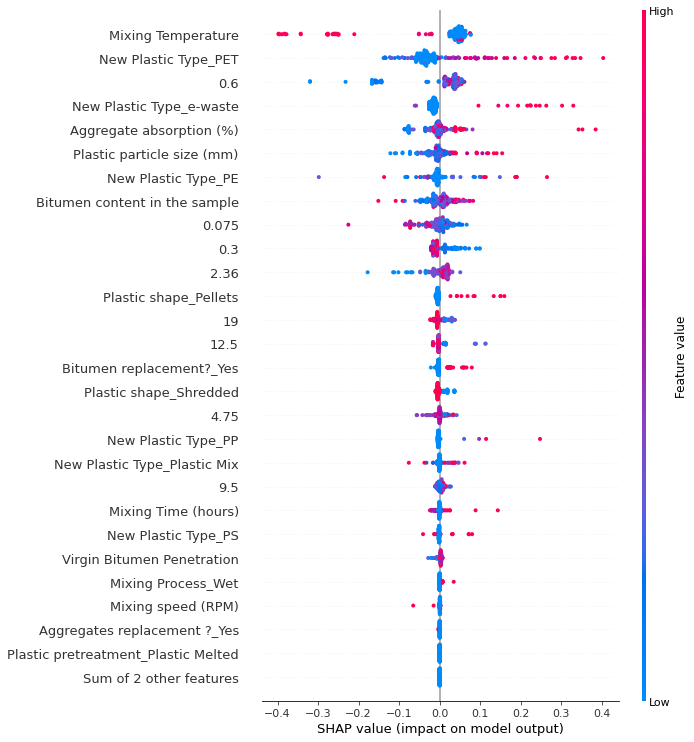

In [19]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=28)

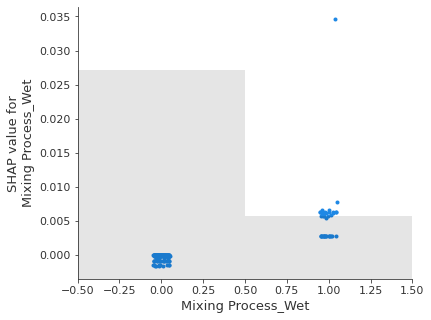

In [20]:
shap.plots.scatter(shap_values[:,'Mixing Process_Wet'])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


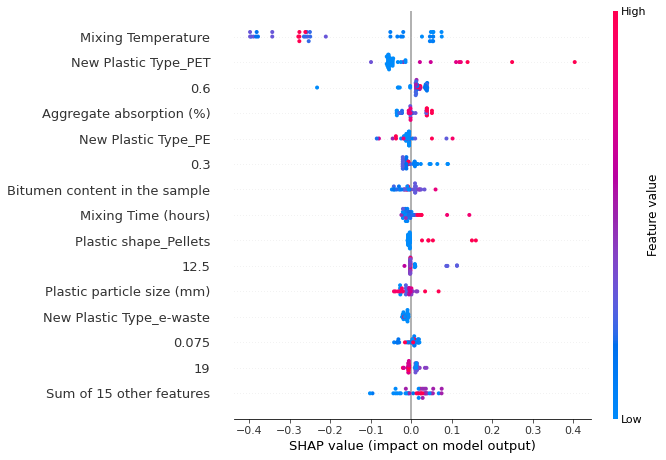

In [21]:
shap_values_wet = explainer(X[X['Mixing Process_Wet'] == 1])
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_wet, max_display=15)

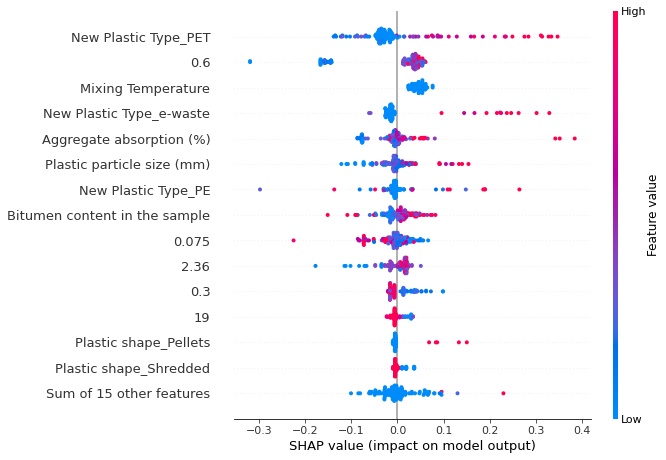

In [22]:
shap_values_dry = explainer(X[X['Mixing Process_Wet'] == 0])
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_dry, max_display=15)